In [71]:
import os
import numpy as np
from copy import deepcopy
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import rasterio
from shapely.geometry import shape
from rasterio.features import geometry_window

from heatmap import count_colors, get_color_counts, plot_color_distribution, reduce_colors, count_colors_by_grid

In [40]:
gdf = gpd.read_file("data/grids_wgs84.geojson")
gdf.head()

,OBJECTID,FID_1,Shape_Leng,Shape_Area,geometry
0,1,22,1000.0,62500.0,"MULTIPOLYGON (((120.58399 31.25646, 120.58393 ..."
1,2,23,1000.0,62500.0,"MULTIPOLYGON (((120.58661 31.25651, 120.58655 ..."
2,3,24,1000.0,62500.0,"MULTIPOLYGON (((120.58923 31.25656, 120.58918 ..."
3,4,25,1000.0,62500.0,"MULTIPOLYGON (((120.59186 31.25661, 120.59180 ..."
4,5,26,1000.0,62500.0,"MULTIPOLYGON (((120.59448 31.25666, 120.59442 ..."


<Axes: >

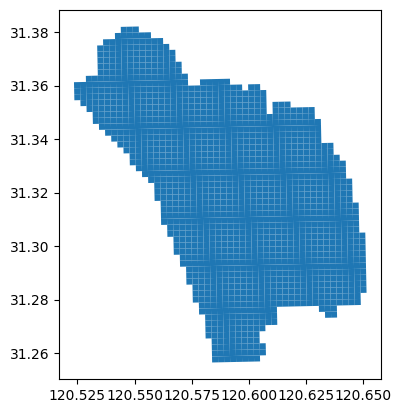

In [3]:
gdf.plot()

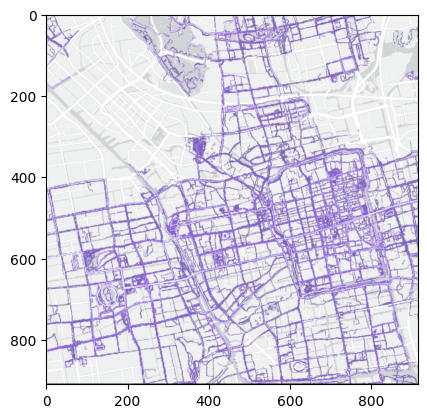

In [4]:
with rasterio.open("data/0923png1.tif") as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)

    red[red == 256] = 0
    green[green == 256] = 0
    blue[blue == 256] = 0

    red = (red / red.max() * 255).astype(np.uint8)
    green = (green / green.max() * 255).astype(np.uint8)
    blue = (blue / blue.max() * 255).astype(np.uint8)

    img = np.dstack((red, green, blue))
    plt.imshow(img)

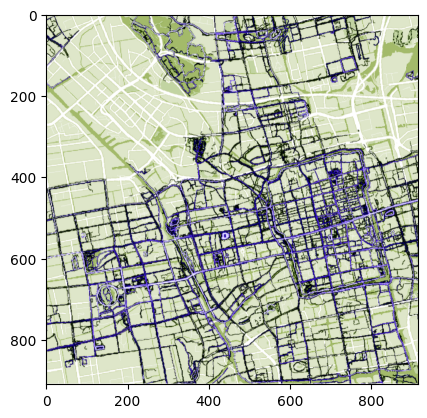

In [5]:
with rasterio.open("data/0923png1.tif") as src:
    red = src.read(1).astype(np.float32)
    green = src.read(2).astype(np.float32)
    blue = src.read(3).astype(np.float32)

    red[red == 256] = 255
    green[green == 256] = 255
    blue[blue == 256] = 255

    # 根据QGIS中的min/max值进行裁剪和归一化
    red = np.clip((red - 129) / (255 - 129), 0, 1)
    green = np.clip((green - 98) / (255 - 98), 0, 1)
    blue = np.clip((blue - 183) / (255 - 183), 0, 1)

    red = (red * 255).astype(np.uint8)
    green = (green * 255).astype(np.uint8)
    blue = (blue * 255).astype(np.uint8)

    img = np.dstack((red, green, blue))
    plt.imshow(img)
    plt.show()

In [6]:
transform = src.transform 
tiff_bounds = src.bounds

grid_to_image_patch = {}

for _, row in gdf.iterrows():
    geom = row["geometry"]
    if geom.is_valid:
        polygon = shape(geom)
        window = geometry_window(src, [polygon], pad_x=0, pad_y=0)
        row_start, row_stop = window.row_off, window.row_off + window.height
        col_start, col_stop = window.col_off, window.col_off + window.width
        indices = [(r, c) for r in range(row_start, row_stop) for c in range(col_start, col_stop)]
        grid_to_image_patch[row["OBJECTID"]] = indices

<Axes: >

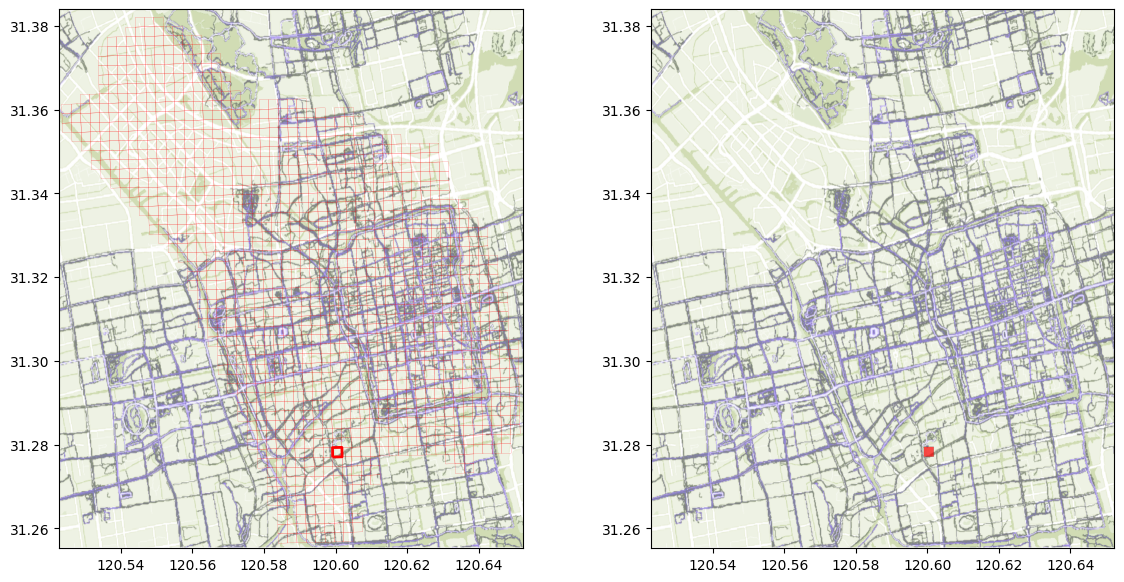

In [7]:
check_id = 104

image_patch = grid_to_image_patch[check_id]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

extent = [tiff_bounds.left, tiff_bounds.right, tiff_bounds.bottom, tiff_bounds.top]

ax1.imshow(img, extent=extent, alpha=0.5)  
gdf.plot(ax=ax1, facecolor="none", edgecolor="red", linewidth=0.1)
# gdf[gdf['OBJECTID'] == check_id].plot(ax=ax1, facecolor='red', edgecolor='none')
gdf[gdf['OBJECTID'] == check_id].plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)

mask = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
for row, col in image_patch:
    mask[row, col, :3] = [255, 0, 0]  
    mask[row, col, 3] = 255  
    
ax2.imshow(img, extent=extent, alpha=0.5) 
ax2.imshow(mask, extent=extent, alpha=0.7)
gdf.plot(ax=ax2, facecolor="none", edgecolor="none")

In [8]:
color_count, labels, simplified_colors, background_colors = get_color_counts(image=img, n_colors=10)

Click on the background colors to select them. Press Enter when done.
Selected background color: [222, 230, 201]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [216, 224, 187]
Selected background color: [172, 193, 120]
Selected background color: [186, 203, 141]
Selected background color: [163, 186, 106]
Selected background color: [194, 212, 162]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [234, 238, 219]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [240, 243, 230]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: [255, 255, 255]
Selected background color: 

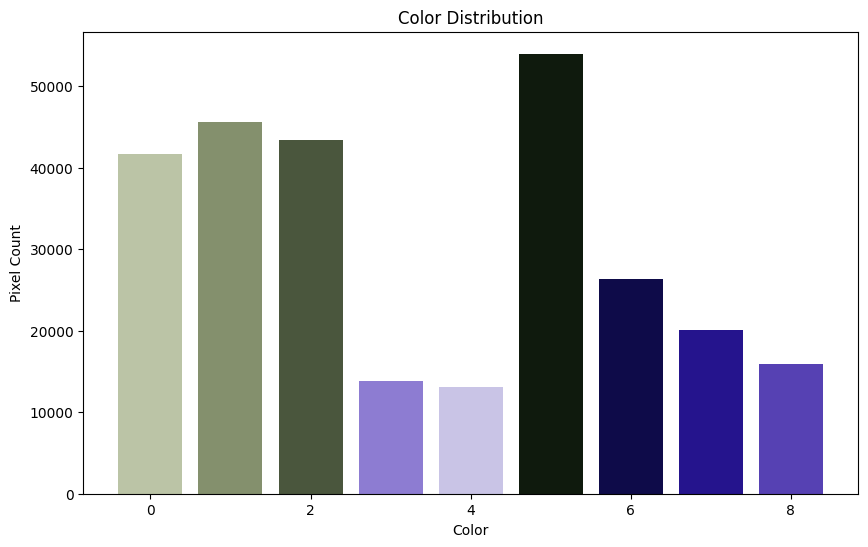

In [9]:
color_count_raw = deepcopy(color_count)

suspect_white = color_count.most_common(1)[0][0]
del color_count[suspect_white]
plot_color_distribution(color_count)

In [10]:
nrow, ncol = img.shape[0], img.shape[1]
grid_to_counter = count_colors_by_grid(labels, simplified_colors, nrow, ncol, background_colors=background_colors, grid_to_img_patch=grid_to_image_patch)

In [16]:
grid_to_counter_raw = deepcopy(grid_to_counter)
for grid_id, grid_color_counter in grid_to_counter.items():
    del grid_color_counter[suspect_white]
    grid_to_counter[grid_id] = grid_color_counter

In [49]:
def rgb_to_hex(rgb):
    """
    将 RGB 颜色转换为十六进制颜色代码。
    """
    return "{:02x}{:02x}{:02x}".format(rgb[0], rgb[1], rgb[2])


gdf_counter = deepcopy(gdf)
for color in color_count:
    gdf_counter[f"c_{rgb_to_hex(color)}"] = None

for idx, row in gdf.iterrows():
    for color in color_count:
        gdf_counter.loc[idx, f"c_{rgb_to_hex(color)}"] = grid_to_counter[row["OBJECTID"]].get(color, 0)

gdf_counter.head()

,OBJECTID,FID_1,Shape_Leng,Shape_Area,geometry,c_bbc4a6,c_84906d,c_4a563d,c_8d7cd2,c_c9c4e6,c_0f1a0d,c_0e0b49,c_25148d,c_5641b3
0,1,22,1000.0,62500.0,"MULTIPOLYGON (((120.58399 31.25646, 120.58393 ...",37,22,31,5,10,37,0,0,5
1,2,23,1000.0,62500.0,"MULTIPOLYGON (((120.58661 31.25651, 120.58655 ...",28,14,28,0,8,31,0,0,0
2,3,24,1000.0,62500.0,"MULTIPOLYGON (((120.58923 31.25656, 120.58918 ...",17,24,17,21,21,4,3,4,8
3,4,25,1000.0,62500.0,"MULTIPOLYGON (((120.59186 31.25661, 120.59180 ...",24,19,20,8,5,57,15,4,3
4,5,26,1000.0,62500.0,"MULTIPOLYGON (((120.59448 31.25666, 120.59442 ...",38,39,23,0,2,66,11,0,0


In [50]:
output_fpath = "output/grid_color_counter.shp"

os.makedirs(os.path.dirname(output_fpath), exist_ok=True)
gdf_counter.to_file(output_fpath)

['c_bbc4a6', 'c_84906d', 'c_4a563d', 'c_8d7cd2', 'c_c9c4e6', 'c_0f1a0d', 'c_0e0b49', 'c_25148d', 'c_5641b3']


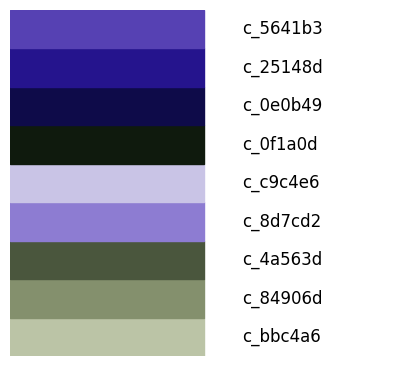

In [67]:
def display_colors(column_names):
    fig, ax = plt.subplots(figsize=(5, len(column_names) * 0.5)) 
    for i, col in enumerate(column_names):
        hex_color = '#' + col.replace('c_', '')
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=hex_color))  
        ax.text(1.2, i + 0.5, col, va='center', fontsize=12)  

    ax.set_xlim(0, 2)
    ax.set_ylim(0, len(column_names))
    ax.axis('off') 
    plt.show()

color_columns = [col for col in gdf_counter.columns if col.startswith("c_")]
print(color_columns)
display_colors(color_columns)

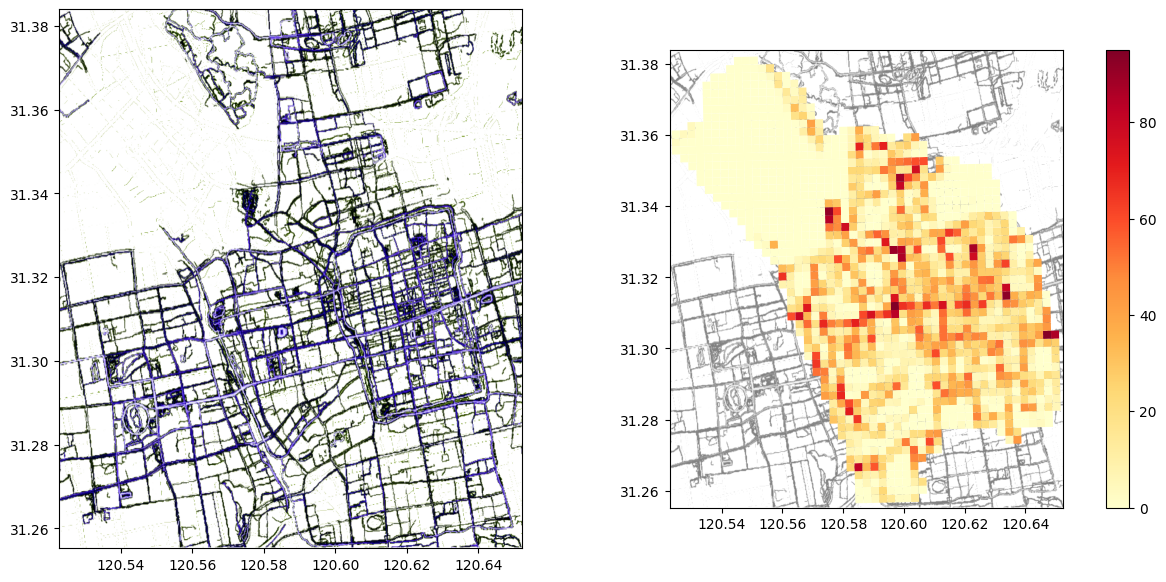

In [72]:
column='c_0e0b49'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

extent = [tiff_bounds.left, tiff_bounds.right, tiff_bounds.bottom, tiff_bounds.top]

ax1.imshow(img, extent=extent)  
gdf.plot(ax=ax1, facecolor="none", edgecolor="none")


ax2.imshow(img[:,:,0], extent=extent, alpha=0.5, cmap="grey") 
gdf_counter.plot(column=column, cmap='YlOrRd', ax=ax2)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=gdf_counter[column].min(), vmax=gdf_counter[column].max()))
sm.set_array([])  
cbar = fig.colorbar(sm, cax=cax)